In [1]:
!pip install qiskit==0.45

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.45.0', 'qiskit-aer': '0.11.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [3]:
!pip install qiskit-aer==0.11

In [4]:
!pip install matplotlib

In [5]:
import matplotlib.pyplot as plt

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.tools.monitor import job_monitor
# from azure.quantum.qiskit import AzureQuantumProvider
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit.utils import QuantumInstance

import numpy as np
from scipy.linalg import block_diag
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult, approx_fprime
import math
# import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument('--trial',type= int, default=0)
# parser.add_argument('--shots',type= int)
# args = parser.parse_args()

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print(eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots

    job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    job = execute(circ_2, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    job = execute(circ_3, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])

    return E



theta_test = [-2]

record_history = history()
shots = 600
trial = 1
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(shots, trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.3822060057999999
theta track:  [-1]
energy track:  -0.5547560058
0.02
theta track:  [-1.9]
energy track:  -0.3719340057999999
theta track:  [-1.88]
energy track:  -0.36770100579999987
0.02
theta track:  [-1.83498728]
energy track:  -0.4106770058
theta track:  [-1.81498728]
energy track:  -0.39152500580000005
0.02
theta track:  [-1.79268737]
energy track:  -0.4053340058
theta track:  [-1.77268737]
energy track:  -0.4052180058
0.02
theta track:  [-1.75808145]
energy track:  -0.3825040058
theta track:  [-1.73808145]
energy track:  -0.3884020057999999
0.02
theta track:  [-1.72685504]
energy track:  -0.3853950058
theta track:  [-1.70685504]
energy track:  -0.40854800579999995
0.02
theta track:  [-1.69278421]
energy track:  -0.3853950058
theta track:  [-1.67278421]
energy track:  -0.37526400579999997
0.02
theta track:  [-1.66624102]
energy track:  -0.4168980058
theta track:  [-1.64624102]
energy track:  -0.40142400579999993
0.02
theta track:  [-1.64764079

Text(0.5, 1.0, 'Qiskit 0.46 - QasmSimulator(shots=600) - NoiseModel() on')

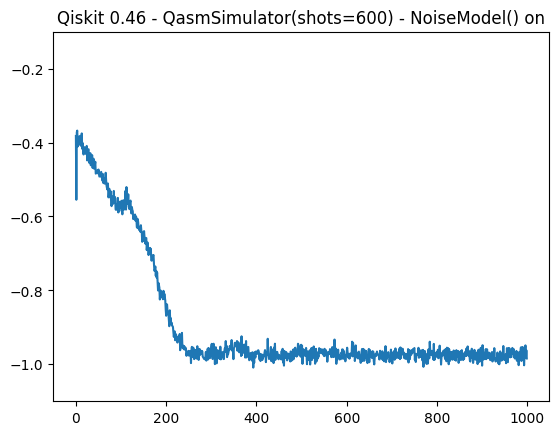

In [9]:
import matplotlib.pyplot as plt 
plt.plot(record_history.energies)
plt.ylim(-1.1, -0.1)
plt.title("Qiskit 0.46 - QasmSimulator(shots=600) - NoiseModel() on")

In [10]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.tools.monitor import job_monitor
# from azure.quantum.qiskit import AzureQuantumProvider
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit.utils import QuantumInstance

import numpy as np
from scipy.linalg import block_diag
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult, approx_fprime
import math
# import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument('--trial',type= int, default=0)
# parser.add_argument('--shots',type= int)
# args = parser.parse_args()

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print(eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots

    job = execute(circ, Aer.get_backend('qasm_simulator'), shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    job = execute(circ_2, Aer.get_backend('qasm_simulator'), shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    job = execute(circ_3, Aer.get_backend('qasm_simulator'), shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])

    return E



theta_test = [-2]

record_history = history()
shots = 600
trial = 1
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(shots, trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.3877560058
theta track:  [-1]
energy track:  -0.5603060058000001
0.02
theta track:  [-1.9]
energy track:  -0.39164100580000005
theta track:  [-1.88]
energy track:  -0.3773930058
0.02
theta track:  [-1.83986283]
energy track:  -0.3952030058
theta track:  [-1.81986283]
energy track:  -0.3702690058000001
0.02
theta track:  [-1.80373685]
energy track:  -0.4098900058
theta track:  [-1.78373685]
energy track:  -0.39619700580000006
0.02
theta track:  [-1.77913542]
energy track:  -0.3742700058
theta track:  [-1.75913542]
energy track:  -0.39908800580000003
0.02
theta track:  [-1.75036167]
energy track:  -0.40866400579999995
theta track:  [-1.73036167]
energy track:  -0.4146780057999999
0.02
theta track:  [-1.72367535]
energy track:  -0.3949710058
theta track:  [-1.70367535]
energy track:  -0.40621200579999994
0.02
theta track:  [-1.6969786]
energy track:  -0.39786200580000003
theta track:  [-1.6769786]
energy track:  -0.41155500580000004
0.02
theta track:  

Text(0.5, 1.0, 'Qiskit 0.46 - QasmSimulator(shots=600) - NoiseModel() off')

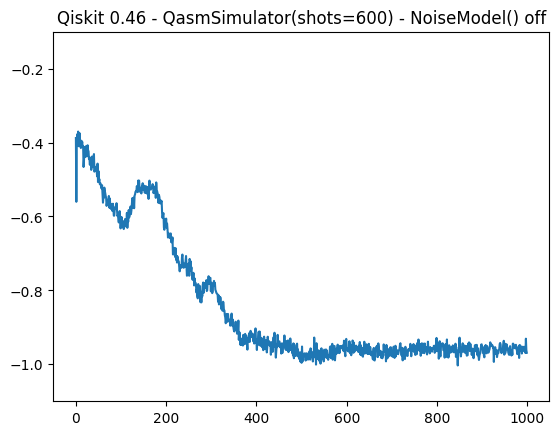

In [11]:
import matplotlib.pyplot as plt 
plt.plot(record_history.energies)
plt.ylim(-1.1, -0.1)
plt.title("Qiskit 0.46 - QasmSimulator(shots=600) - NoiseModel() off")